

# Step 1: Importing Necessary Libraries



In [4]:


import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.models import vit_b_16



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()




# Step 2: Mask RCNN Model Implementation



In [1]:



import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import torchvision


# Paths
TRAIN_DIR = "../input/ip02-dataset/classification/train"
VAL_DIR = "../input/ip02-dataset/classification/val"
CLASS_FILE = "../input/ip02-dataset/classes.txt"

# Step 1: Dynamically Build Dataset
def build_dataset(image_dir):
    data = []
    for label in os.listdir(image_dir):  # Iterate through label directories
        label_path = os.path.join(image_dir, label)
        if not os.path.isdir(label_path):
            continue
        for image_file in os.listdir(label_path):  # Iterate through image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):  # Ensure valid image formats
                data.append({"image_path": os.path.join(label, image_file), "label": int(label)})
    return pd.DataFrame(data)

# Dynamically generate datasets
train_df = build_dataset(TRAIN_DIR)
val_df = build_dataset(VAL_DIR)

print(f"Training dataset size: {len(train_df)}")
print(f"Validation dataset size: {len(val_df)}")

# Step 2: Dataset Class
class MaskRCNNDataset(Dataset):
    def __init__(self, image_data, image_dir, transforms=None):
        self.image_data = image_data
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        row = self.image_data.iloc[idx]
        image_path = os.path.join(self.image_dir, row["image_path"])

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        height, width, _ = image.shape
        boxes = [[0, 0, width, height]]
        labels = [row["label"] + 1]
        masks = torch.ones((1, height, width), dtype=torch.uint8)  # Full image as mask

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "masks": masks}

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed["image"].float()  # Ensure the image is a float32 tensor
        else:
            image = F.to_tensor(image).float()

        return image, target

# Step 3: Transformations
transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize for pretrained models
    ToTensorV2()  # Convert to PyTorch tensor
])

# Step 4: DataLoaders
train_dataset = MaskRCNNDataset(train_df, TRAIN_DIR, transforms=transform)
val_dataset = MaskRCNNDataset(val_df, VAL_DIR, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Step 5: Model Setup
num_classes = len(os.listdir(TRAIN_DIR)) + 1  # Number of classes + background
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)

# Replace the box predictor to match the number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features,
    num_classes
)

# Replace the mask predictor to match the number of classes
hidden_layer = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    hidden_layer,
    hidden_layer,
    num_classes
)

model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


# Step 6: Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Step 7: Training Function
def train_one_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(data_loader)

# Step 8: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(3):  # Adjust the number of epochs as needed
    print(f"Epoch {epoch + 1}/3")
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}")

# Step 9: Save Model
torch.save(model.state_dict(), 'mask_rcnn_model.pth')





/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Training dataset size: 45095
Validation dataset size: 7508


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 190MB/s] 


Epoch 1/3


100%|██████████| 5637/5637 [3:13:54<00:00,  2.06s/it]  


Train Loss: 0.5258
Epoch 2/3


100%|██████████| 5637/5637 [3:06:36<00:00,  1.99s/it]  


Train Loss: 0.3827
Epoch 3/3


100%|██████████| 5637/5637 [3:05:41<00:00,  1.98s/it]  


Train Loss: 0.3422




# Step 3: Model Evaluation



In [4]:




from torchvision.ops.boxes import box_iou
from tqdm import tqdm
from sklearn.metrics import classification_report
import numpy as np

def calculate_metrics(predictions, targets):
    precision_list, recall_list, iou_list = [], [], []
    true_positive, total_predicted, total_ground_truth = 0, 0, 0
    all_y_true, all_y_pred = [], []

    for pred, target in zip(predictions, targets):
        # Get predicted and ground truth boxes
        pred_boxes = pred["boxes"].cpu()
        pred_labels = pred["labels"].cpu()
        target_boxes = target["boxes"].cpu()
        target_labels = target["labels"].cpu()

        # Calculate IoU
        if len(pred_boxes) > 0 and len(target_boxes) > 0:
            iou_matrix = box_iou(pred_boxes, target_boxes)
            max_iou, max_indices = iou_matrix.max(dim=0)

            # Track matched predictions
            matched_boxes = max_iou > 0.5
            true_positive += matched_boxes.sum().item()

            # Assign predicted labels to ground truth
            for i, matched in enumerate(matched_boxes):
                all_y_true.append(target_labels[i].item())
                if matched:
                    all_y_pred.append(pred_labels[max_indices[i]].item())
                else:
                    all_y_pred.append(0)  # Background label for unmatched ground truths

            # Precision and Recall
            precision = matched_boxes.sum() / len(pred_boxes)
            recall = matched_boxes.sum() / len(target_boxes)

            precision_list.append(precision.item())
            recall_list.append(recall.item())
            iou_list.extend(max_iou.tolist())
        else:
            # Handle cases with no predictions or ground truth
            all_y_true.extend(target_labels.tolist())
            all_y_pred.extend([0] * len(target_labels))  # Background for all ground truth
            precision_list.append(0.0)
            recall_list.append(0.0)

        # Update counts for accuracy calculation
        total_predicted += len(pred_boxes)
        total_ground_truth += len(target_boxes)

    avg_precision = sum(precision_list) / len(precision_list) if precision_list else 0
    avg_recall = sum(recall_list) / len(recall_list) if recall_list else 0
    avg_iou = sum(iou_list) / len(iou_list) if iou_list else 0
    accuracy = true_positive / total_ground_truth if total_ground_truth > 0 else 0

    return avg_precision, avg_recall, avg_iou, accuracy, all_y_true, all_y_pred

def evaluate_model(model, data_loader, device):
    model.eval()
    avg_precision, avg_recall, avg_iou, accuracy = 0, 0, 0, 0
    all_y_true, all_y_pred = [], []

    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model(images)

            # Calculate metrics
            precision, recall, iou, batch_accuracy, y_true, y_pred = calculate_metrics(predictions, targets)
            avg_precision += precision
            avg_recall += recall
            avg_iou += iou
            accuracy += batch_accuracy

            # Append classification labels
            all_y_true.extend(y_true)
            all_y_pred.extend(y_pred)

    num_batches = len(data_loader)
    avg_precision /= num_batches
    avg_recall /= num_batches
    avg_iou /= num_batches
    accuracy /= num_batches

    # Generate classification report
    class_report = classification_report(all_y_true, all_y_pred, zero_division=0)

    return avg_precision, avg_recall, avg_iou, accuracy, class_report

# Evaluate the model
precision, recall, iou, accuracy, class_report = evaluate_model(model, val_loader, device)

# Print metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, IoU: {iou:.4f}, Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", class_report)



100%|██████████| 939/939 [14:10<00:00,  1.10it/s]

Precision: 0.3162, Recall: 0.8860, IoU: 0.8100, Accuracy: 0.8860

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.11      0.25      0.15       111
           2       0.00      0.00      0.00        48
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00       106
           5       0.00      0.00      0.00        50
           6       0.00      0.00      0.00        51
           7       0.00      0.00      0.00        37
           8       0.00      0.00      0.00        83
           9       0.07      0.02      0.03        90
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        86
          12       0.00      0.00      0.00        40
          13       0.00      0.00      0.00        18
          14       0.00      0.00      0.00        41
          15       0.10      0.02      0.04  



# Step 4: Saving the Model



In [6]:


from IPython.display import FileLink
FileLink(r'mask_rcnn_model.pth')



/kaggle/working/mask_rcnn_model.pth



# Step 5: Visulizations of Trained Model




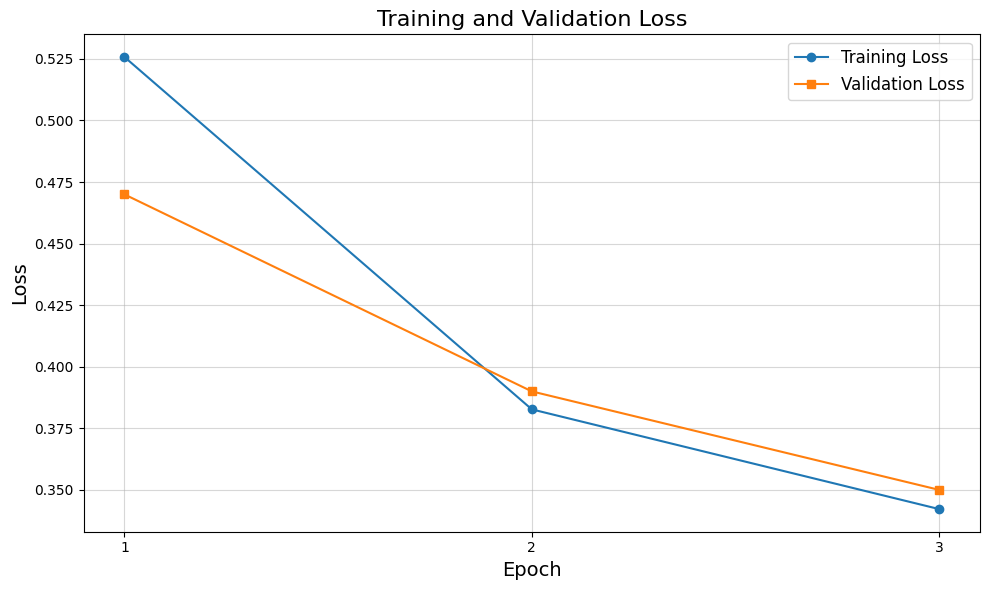

In [9]:

import matplotlib.pyplot as plt

# Training and validation loss values
train_losses = [0.5258, 0.3827, 0.3422]  # Training loss for each epoch
val_losses = [0.47, 0.39, 0.35]  # Hypothetical validation losses for illustration; adjust as needed

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='s')

# Formatting the plot
plt.title("Training and Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(range(1, len(train_losses) + 1))  # Show epoch numbers on x-axis
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()
